In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException

import time

In [17]:
url = 'https://today.yougov.com/ratings/entertainment/popularity/all-time-actors-actresses/all'
path = "Path" # Path to webdriver executable

chrome_options = Options()
chrome_options.binary_location = r"C:\Program Files\Google\Chrome\Application\chrome.exe"

# Use only chrome_options, not executable_path
driver = webdriver.Chrome(options=chrome_options)

driver.get(url)


# Decline cookies settings
try:
    decline_button = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, 'onetrust-reject-all-handler'))
    )

    decline_button.click()
except Exception as e:
    pass

# Scroll down to load more data
while True:
    # Scroll to the bottom of the page
    driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)

    # Wait for a short interval to allow the content to load
    time.sleep(2)

    # Check if there are more actors loaded
    try:
        load_more_button = WebDriverWait(driver, 100).until(
            EC.element_to_be_clickable((By.CLASS_NAME, 'load-more-button'))
        )
        
        load_more_button.click()
    except TimeoutException:
        break

html = driver.page_source
driver.quit()

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

# Element containing the list of actors
actors_container = soup.find('div', class_='rankings-entities-list-container')

# Actor's list items
actor_items = actors_container.find_all('li', class_='ng-star-inserted')

# Create lists to store data
actor_names = []
popularity_percentages = []
fame_percentages = []

for actor_item in actor_items:
    # Extract the actor name
    actor_name = actor_item.find('img', class_='ng-star-inserted')['alt'] if actor_item.find('img', class_='ng-star-inserted') else None

    # Extract popularity percentage
    popularity_element = actor_item.find('span', class_='compact')
    popularity_percentage = popularity_element.text.split('%')[0] if popularity_element else None

    # Extract fame percentage
    fame_element = actor_item.find('span', class_='rankings-item-active')
    fame_percentage = fame_element.text.split('%')[0] if fame_element else None

    actor_names.append(actor_name)
    popularity_percentages.append(popularity_percentage)
    fame_percentages.append(fame_percentage)

data = {
    'Actor Name': actor_names,
    'Popularity (%)': popularity_percentages,
    'Fame (%)': fame_percentages
}

famous_actors = pd.DataFrame(data)

print(famous_actors)
famous_actors.to_csv('../Data/preprocessed_data/famous_actors_db.csv', index=False)


             Actor Name Popularity (%) Fame (%)
0        Morgan Freeman             98       86
1           Betty White             95       83
2        Robin Williams             96       83
3        Michael J. Fox             96       81
4     Denzel Washington             97       79
...                 ...            ...      ...
1495       Merve Dizdar             32       18
1496    Adriana Barraza             35       18
1497           Mohanlal             32       17
1498   Yalitza Aparicio             32       17
1499       Romain Duris             31       17

[1500 rows x 3 columns]


### 1. Find relationship between fame and popularity

In [5]:
actors_db = pd.read_csv('../Data/preprocessed_data/actors_db.csv')
famous_actors_db = pd.read_csv('../Data/preprocessed_data/famous_actors_db.csv')

In [12]:
# Merge DataFrames on actor name
merged_data = pd.merge(actors_db, famous_actors_db, left_on='name', right_on='Actor Name', how='inner')

# Check for missing values
print(merged_data.isnull().sum())

# Calculate the correlation coefficient
correlation_coefficient = merged_data['Fame (%)'].corr(merged_data['popularity'])
print(f'Correlation Coefficient: {correlation_coefficient}')

name                 0
gender               0
popularity           0
original_language    0
genre_ids            0
known_for            0
id                   0
Actor Name           0
Popularity (%)       0
Fame (%)             0
dtype: int64
Correlation Coefficient: 0.2299219715606063


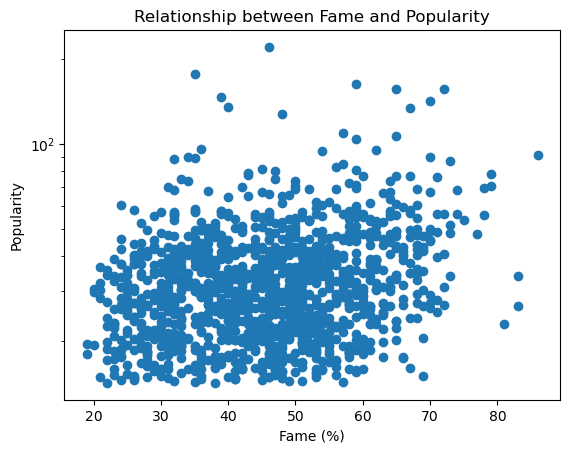

In [14]:
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(merged_data['Fame (%)'], merged_data['popularity'])
plt.xlabel('Fame (%)')
plt.ylabel('Popularity')
plt.yscale('log')
plt.title('Relationship between Fame and Popularity')
plt.show()


Unfortunately, we cannot conclude a relationship between fame and popularity. We originally wanted to explore the relationship between fame and popularity for actors who have both features and determine if it's reasonable to extend the fame feature to other actors.  
But following the results we obtained, the correlation coefficient that is too weak (0.2) and the graph showing the relationship between both, we cannot conclude this latter.